In [1]:
here::i_am("Code/cluspropAnalysis/cluspropFigures/revision_figures_final.ipynb")

here() starts at /accounts/projects/epurdom/singlecell/pop_data



In [2]:
library(dplyr)
library(ggplot2)
library(tibble)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
combined_data_long <- readRDS(here::here("results","Revision","figures","combined_data_long.RDS"))

In [4]:
plot_data <- dplyr::filter(combined_data_long, gs_transform == "none")

In [5]:
datasets <- c("stephensonCOVIDPBMCfilter","perezLupus")
clustering_algorithms <- c("Leiden")
statistics <- c("silhouette","R")
separation_vars <- c("batch")

leiden_resolutions <- c(1e-4,1e-5,5e-5,6e-5)
louvain_resolutions <- c(0.1,0.8,2,5)

In [6]:
dataset_str <- datasets[1]
algorithm_str <- clustering_algorithms[1]
resolutions_vec <- if(algorithm_str == "leiden") leiden_resolutions else louvain_resolutions
statistic_value <- statistics[2]
separation_variable <- separation_vars[1]

## Individual Plots

In [7]:
x_map_discrete <- function(tibble_row){
    method <- tibble_row["method"]
    num_components <- tibble_row["num_components"]
    resolution <- tibble_row["resolution"]
    if (method == "GloScopeGMM" & num_components == 5){
        return("G = 5")
    } else if (method == "GloScopeGMM" & num_components == 10){
        return("G = 10")
    } else if (method == "GloScopeGMM" & num_components == 15){
        return("G = 15")
    } else if (method == "GloScopeGMM" & num_components == "Default"){
        return("G = BIC")
    } else if (method %in% c("GloScopeProp", "PILOT") & resolution == 0.1){
        return("Res. = 0.1")
    } else if (method %in% c("GloScopeProp", "PILOT") & resolution == 1e-4){
        return("Res. = 1e-4")
    } else if (method %in% c("GloScopeProp", "PILOT") & resolution == 0.8){
        return("Res. = 0.8")
    } else if (method %in% c("GloScopeProp", "PILOT") & resolution == 1e-5){
        return("Res. = 1e-5")
    } else if (method %in% c("GloScopeProp", "PILOT") & resolution == 2){
        return("Res. = 2")
    } else if (method %in% c("GloScopeProp", "PILOT") & resolution == 5e-5){
        return("Res. = 5e-5")
    } else if (method %in% c("GloScopeProp", "PILOT") & resolution == 5){
        return("Res. = 5")
    } else if (method %in% c("GloScopeProp", "PILOT") & resolution == 5e-6){
        return("Res. = 5e-6")
    } else{
        return(NA)
    }
}


In [71]:
return_dataset_stat_plot <- function(dataset_str, algorithm_str, resolutions_vec, statistic_value, separation_variable){
    dataset_stat_tibble <- plot_data %>%
        filter(method != "GloScopeKNN") %>%
        filter(k %in% c(20, NA)) %>%
        filter(separation_var == separation_variable) %>%
        filter(dataset == dataset_str) %>%
        filter(algorithm %in% c(algorithm_str, "No Clustering")) %>%
        filter(statistic == statistic_value)

    x_vec <- apply(dataset_stat_tibble[,c("method", "num_components", "resolution")],1,x_map_discrete)
    dataset_stat_tibble <- dataset_stat_tibble %>%
        mutate(x_axis_pos = x_vec) %>%
        mutate(`Default` = ifelse(resolution %in% c(0.8, 1e-5) | num_components %in% c("Default"),
            TRUE,FALSE))
    dataset_stat_tibble <- mutate(dataset_stat_tibble, method = dplyr::recode_factor(method,
        "GloScopeGMM" = "GloScope", "GloScopeProp" = "GloProp"))
    
    dataset_stat_plot <- ggplot(dataset_stat_tibble, aes(x=x_axis_pos, y = value)) + 
        geom_point(aes(shape = `Default`),size = 16, alpha = 1) +
        scale_shape(solid = FALSE) +
        facet_grid(.~ method, space = 'free_x', scales = 'free_x', switch = 'x') +
        labs(title = NULL,
            x = NULL, y = paste0(stringr::str_to_title(statistic_value), " Statistic Value")) +
        theme_classic() +
        theme(panel.grid.minor.x = element_blank()) + 
        theme(panel.spacing.x = unit(0,"line")) +
        theme(strip.placement = 'outside',
            strip.background.x = element_blank(),
            axis.text.x.bottom  = element_text(angle = 290, size = 36, vjust = 0.1, hjust = 0.2),
            strip.text.x = element_text(angle = 0, size = 48),
            axis.text.y.left  = element_text(angle = 0, size = 36),
            axis.title.y.left  = element_text(angle = 90, size = 48),
            panel.background = element_rect(fill = NA, color = "black"),
            axis.ticks.x = element_blank(),
            plot.margin = margin(0.5,1,0.5,0.5,"in"),
            legend.position="none")
    
    return(dataset_stat_plot)
}

In [72]:
datasets <- c("stephensonCOVIDPBMCfilter","perezLupus")
clustering_algorithms <- c("Leiden")
statistics <- c("silhouette","R")
separation_vars <- c("batch")

plot_list <- list()
for (dataset_str in datasets){
    for (algorithm_str in clustering_algorithms){
        resolutions_vec <- if(algorithm_str == "leiden") leiden_resolutions else louvain_resolutions
        for (statistic_value in statistics){
            for (separation_variable in separation_vars){
                plot_str <- paste0(dataset_str,"_",statistic_value,"_",separation_variable)
                generated_plot <- return_dataset_stat_plot(dataset_str, algorithm_str, resolutions_vec, statistic_value, separation_variable)
                plot_list[[plot_str]] <- generated_plot
            }     
        }
    }
}

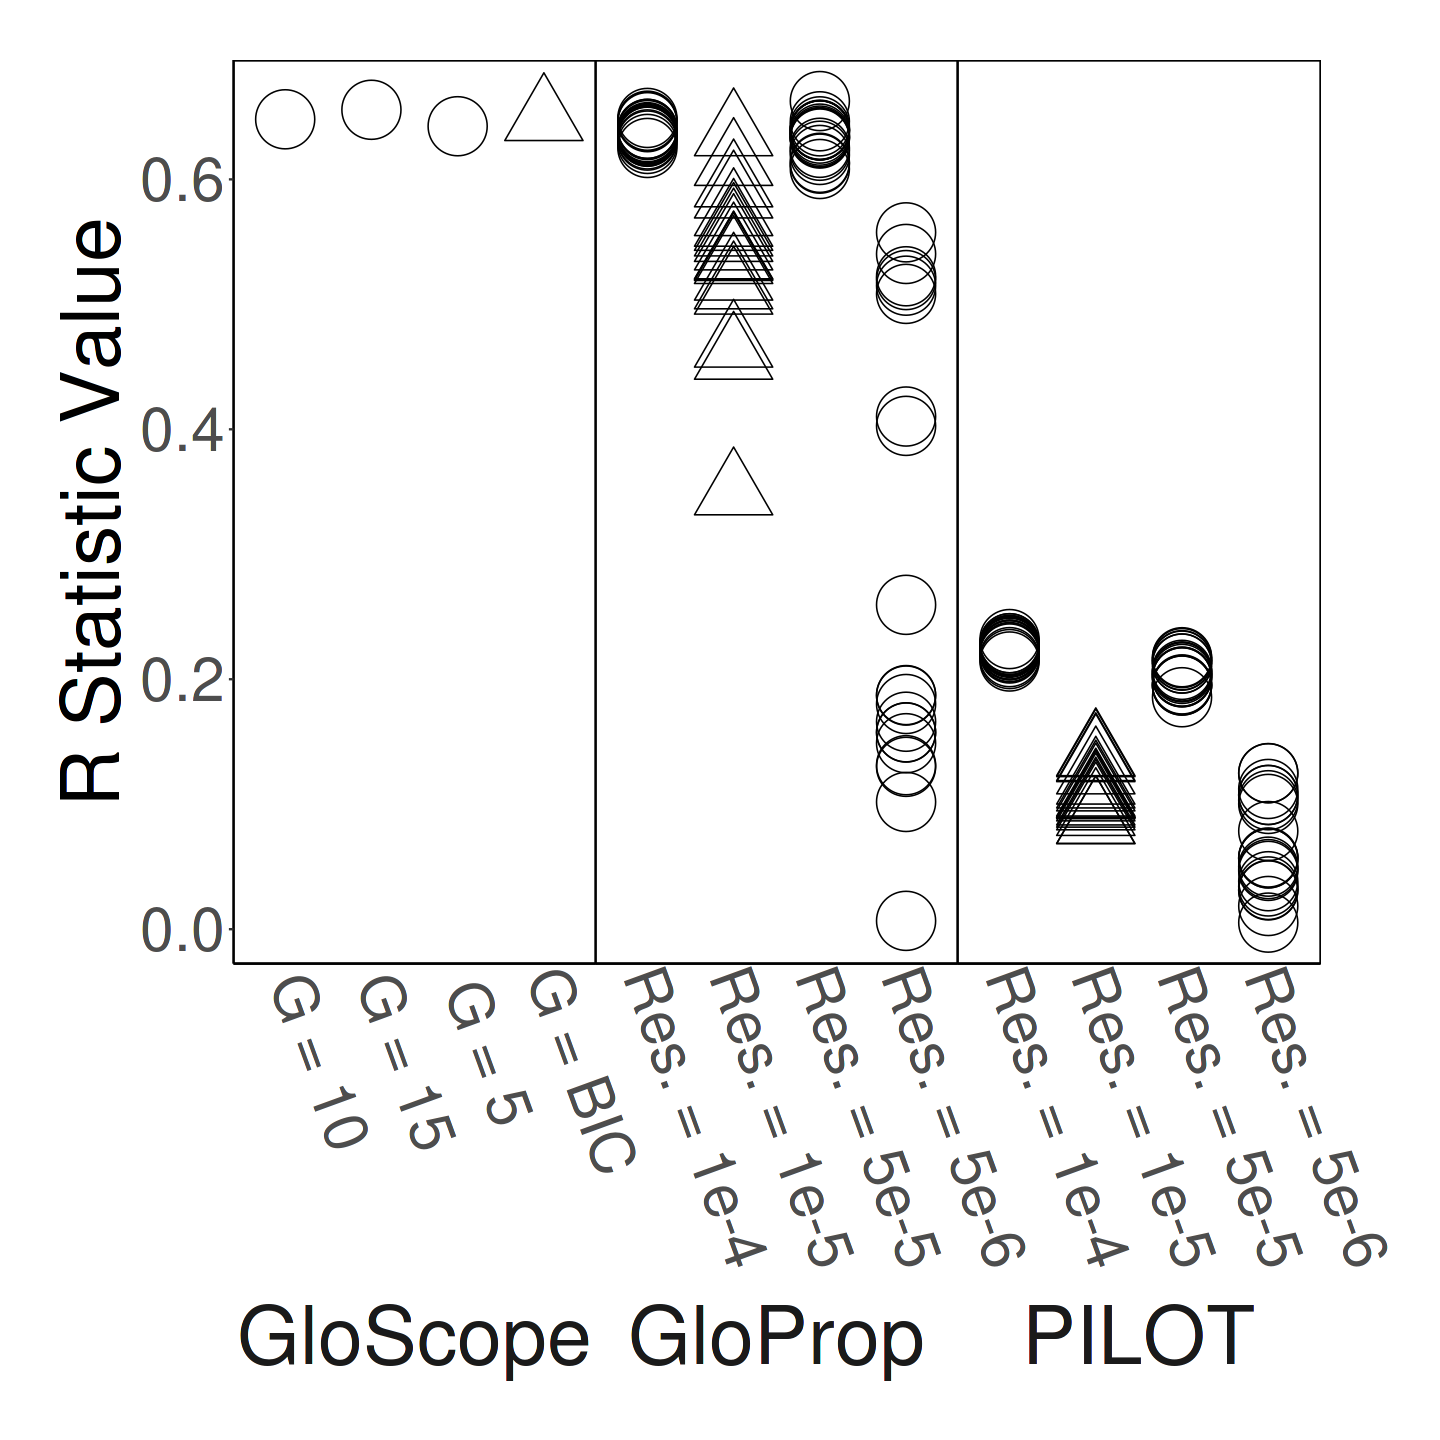

In [73]:
options(repr.plot.width=12, repr.plot.height=12)
generated_plot

In [74]:
j <- lapply(names(plot_list),function(plot_name){
    ggplot <- plot_list[[plot_name]]
    ggsave(here::here("results","Revision","figures",paste0("cluspropInd_",plot_name,".png")),device = "png",
        height = 14, width = 14)
    return(ggplot)
})

In [75]:
names(plot_list)

[1] "stephensonCOVIDPBMCfilter_silhouette_batch"
[2] "stephensonCOVIDPBMCfilter_R_batch"         
[3] "perezLupus_silhouette_batch"               
[4] "perezLupus_R_batch"

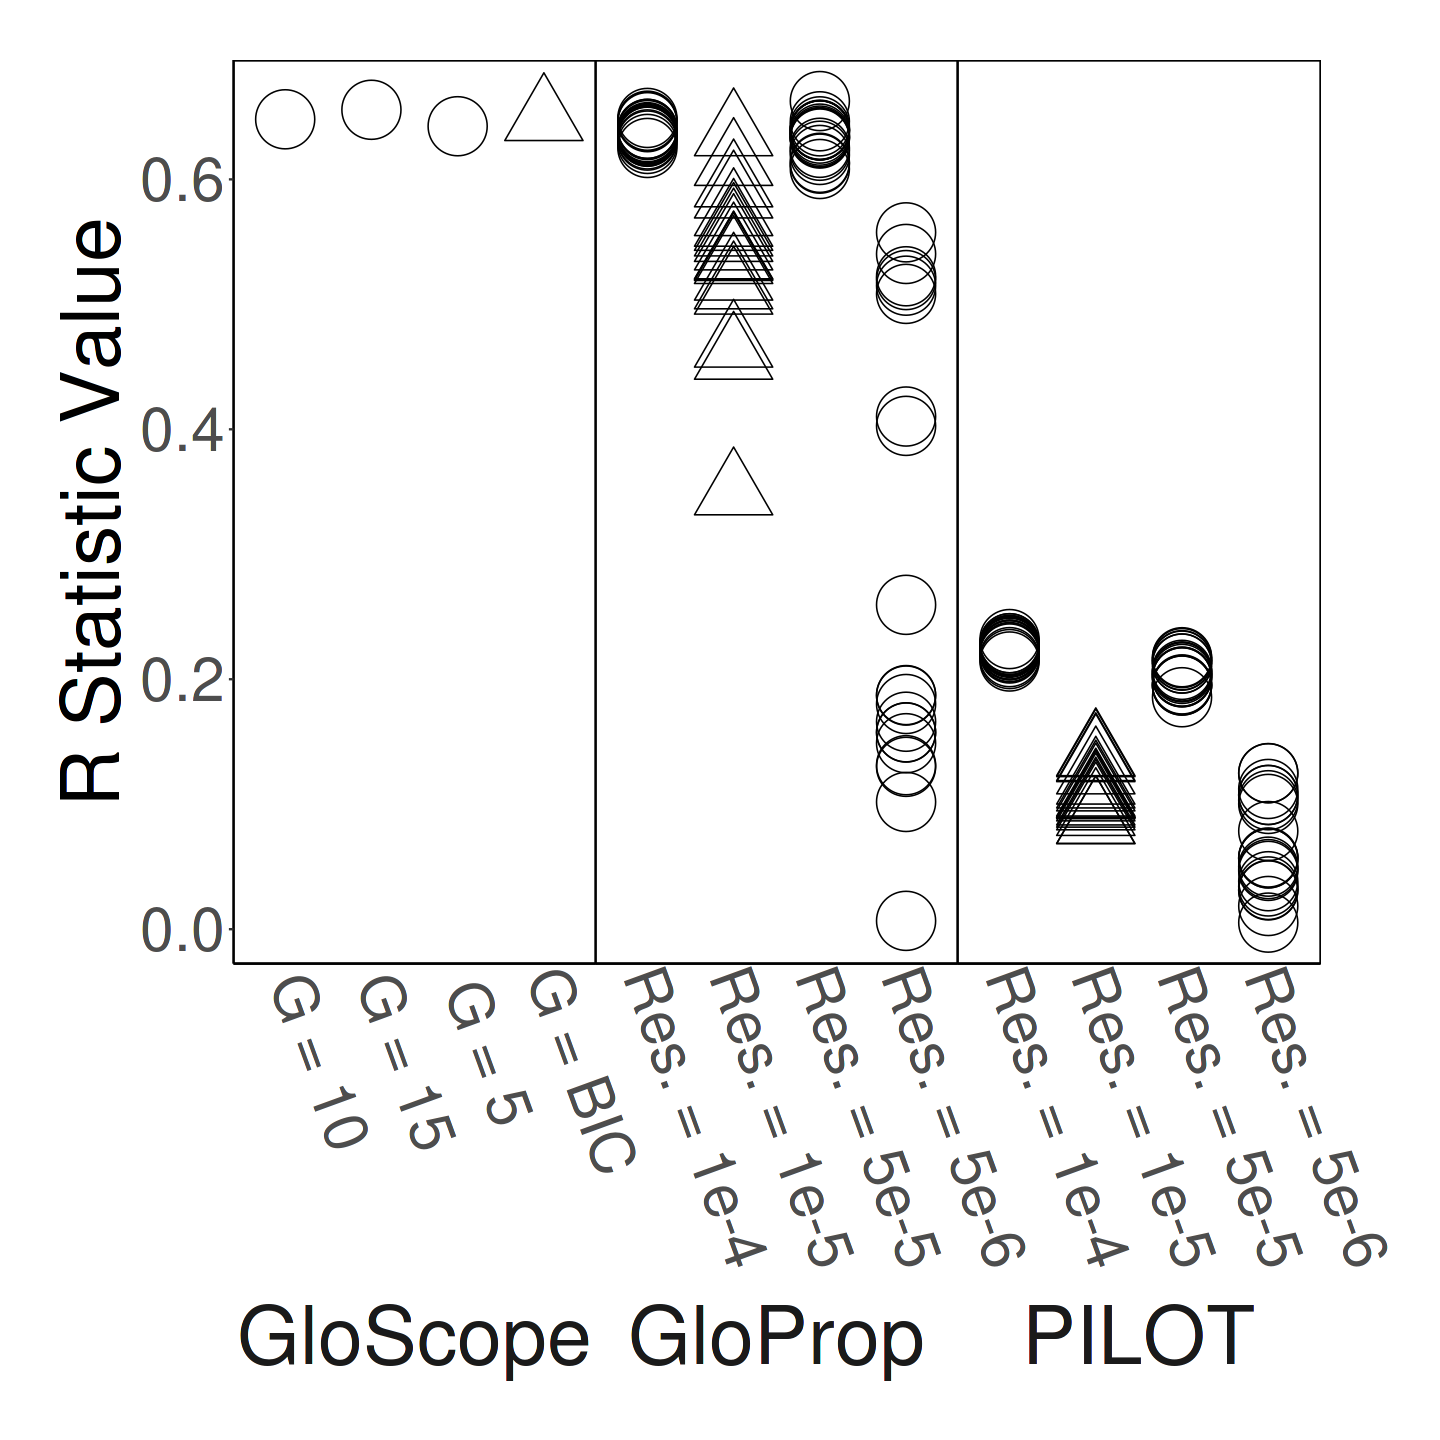

In [81]:
j[[4]]

## Unified Comparison Figure

In [14]:
x_map_comp <- function(tibble_row){
    method <- tibble_row["method"]
    num_components <- tibble_row["num_components"]
    resolution <- tibble_row["resolution"]
    if (method == "GloScopeGMM"){
        return(0)
    } else if (method == "GloScopeProp"){
        return(0.5)
    } else if (method == "PILOT"){
        return(1)
    } else {
        return(NA)
    }
}

break_vec <- c(0,0.5,1)
label_vec <- c("GloScope", "GloProp", "PILOT")

In [23]:
default_comp_tibble <- plot_data %>%
    filter(method != "GloScopeKNN") %>%
    filter(dataset != "stephensonCOVIDPBMCfilter") %>%
    filter(!(algorithm %in% c("Annotation","Louvain"))) %>%
    filter(k %in% c(20, NA)) %>%
    filter(num_components %in% c("Default", NA)) %>%
    filter(resolution %in% c(1e-5, 0.8, NA)) %>%
    filter(separation_var == "batch")

default_comp_tibble_clusprop <- filter(default_comp_tibble,method != "GloScopeGMM")
default_comp_tibble_gs_leiden <- default_comp_tibble %>%
    filter(method == "GloScopeGMM") %>%
    mutate(algorithm = "Leiden")
default_comp_to_plot <- rbind(default_comp_tibble_clusprop, default_comp_tibble_gs_leiden)

x_vec <- apply(default_comp_to_plot[,c("method", "num_components", "resolution")],1,x_map_comp)
default_comp_to_plot <- mutate(default_comp_to_plot, x_axis_pos = x_vec)

default_comp_to_plot <- mutate(default_comp_to_plot, dataset = dplyr::recode_factor(dataset,
    "fabreLiver" = "Liver Fibrosis", "fabreLung" = "Lung Fibrosis",
    "perezLupus" = "Lupus PBMC", "stephensonCOVIDPBMCsubset" = "COVID PBMC"))

In [24]:
dataset_stat_plot <- ggplot(filter(default_comp_to_plot, statistic == "R")) + 
    geom_point(aes(x=x_axis_pos, y = value),size = 20, alpha = 1, shape = 1) +
    scale_x_continuous(breaks=break_vec,labels=label_vec, limits = c(-0.25,1.25)) +
    scale_shape(solid = FALSE) +
    facet_grid(.~ dataset, space = 'fixed', scales = 'free_x', switch = 'y') +
    labs(title = NULL,
        x = NULL, y = paste0(stringr::str_to_title(statistic_value), " Statistic Value")) +
    theme_classic() +
    theme(panel.grid.minor.x = element_blank()) + 
    theme(panel.spacing.x = unit(0,"line")) +
    theme(strip.placement = "outside",
        strip.background.x = element_blank(),
        axis.text.x.bottom  = element_text(angle = 290, size = 32, vjust = 0, hjust = 0.3),
        strip.text.x = element_text(angle = 0, size = 40),
        axis.text.y.left  = element_text(angle = 0, size = 32),
        axis.title.y.left  = element_text(angle = 90, size = 40),
        panel.background = element_rect(fill = NA, color = "black"),
        legend.position="none",
        plot.margin = margin(0.5,0.5,0.5,0.5,"in"))

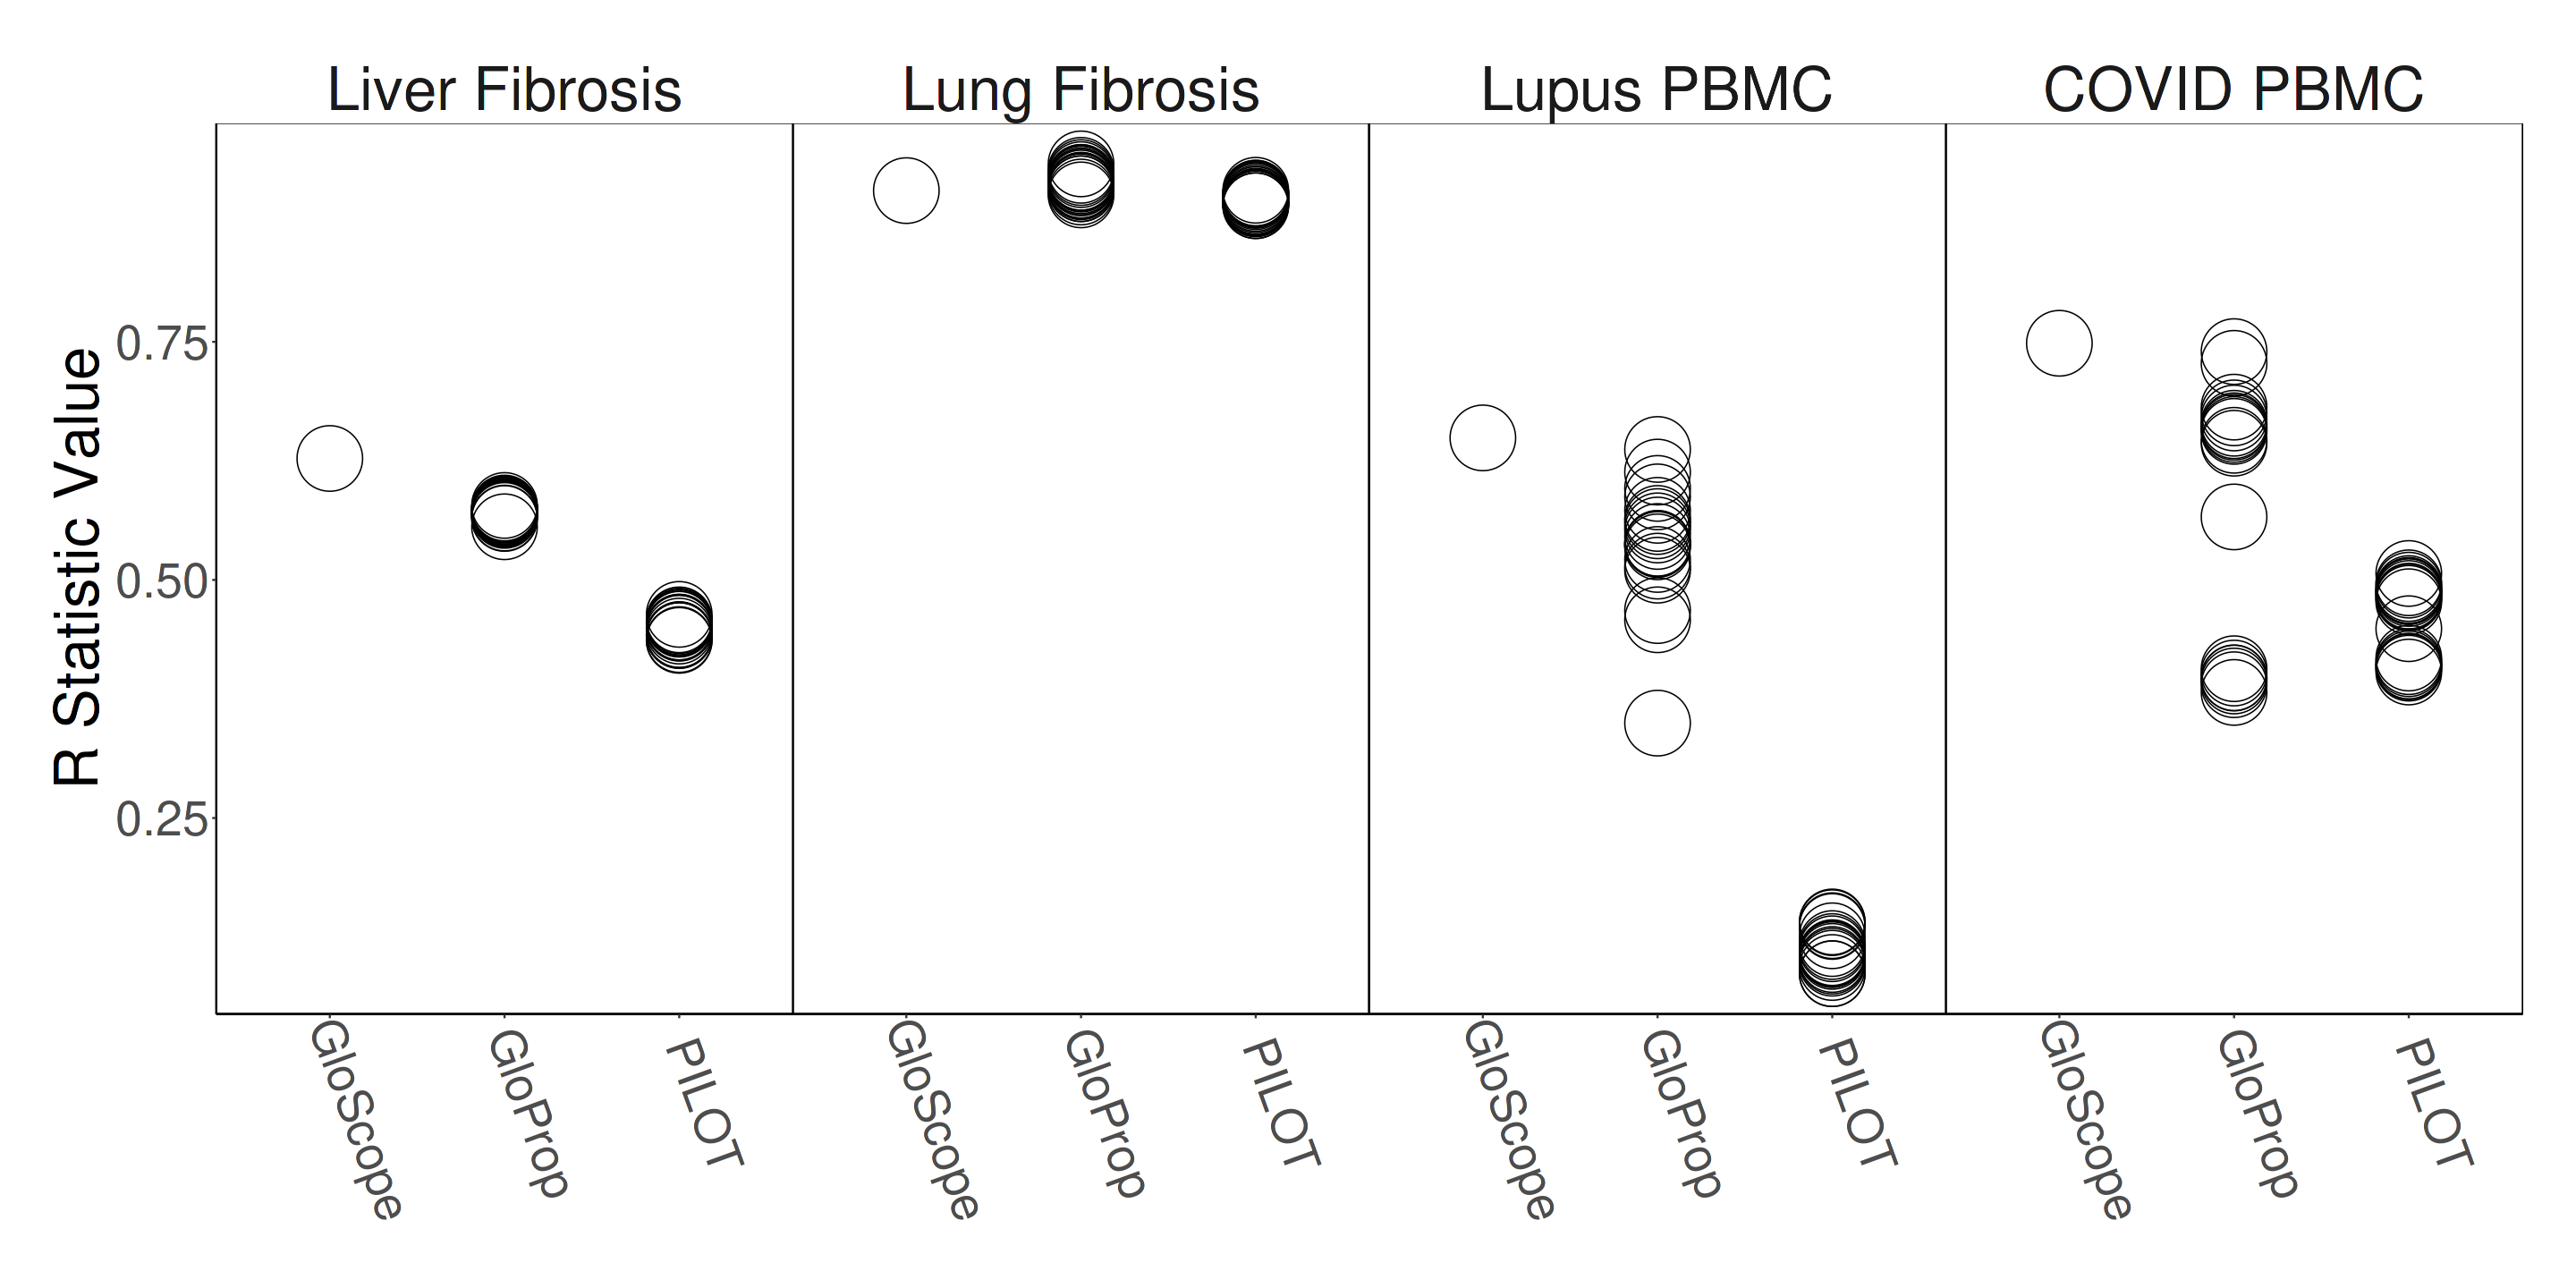

In [25]:
options(repr.plot.width=24, repr.plot.height=24/2)
dataset_stat_plot

In [19]:
default_comp_plot_R <- ggplot2::ggplot(filter(default_comp_to_plot, statistic == "R")) +
    geom_point(aes(x = x_axis_pos, y = value),size = 10,alpha = 1, shape = 1) +
    scale_x_continuous(breaks=break_vec,labels=label_vec) +
    theme_classic() +
    labs(x = "Method", y = "R Statistic Value", title = NULL) +
                    theme(plot.title = element_text(size=30),
                        strip.text.x = element_text(size = 24, angle = 0),
                        axis.text.x.bottom  = element_text(angle = 290, size = 18, vjust = 0, hjust = 0.2),
                        axis.title.x.bottom  = element_text(size = 24),
                        axis.text.y.left  = element_text(angle = 0, size = 18),
                        axis.title.y.left  = element_text(angle = 90, size = 24)) +
    facet_wrap(vars(dataset),ncol = 4))

ERROR: Error in parse(text = x, srcfile = src): <text>:12:39: unexpected ')'
11:                         axis.title.y.left  = element_text(angle = 90, size = 24)) +
12:     facet_wrap(vars(dataset),ncol = 4))
                                          ^
